# Path Planning Force Based

In this notebook A* is applied to an quadrotor.

Obstacle 1 has no obstacle, the quadrotor should only fly horizontally from one position to another

In [9]:
#import the needed libraries
#%matplotlib notebook
%matplotlib inline
import numpy as np
from Path_Search import *
from Quadrotor_Load import *
import matplotlib.pylab as plt
import Node
import scipy.io as sio

In [10]:
import matplotlib
#used to create nice graph to use in latex
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 8,
          'axes.labelsize': 8,
          'axes.titlesize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'font.family': 'serif',
          #'figure.figsize' : [5.8, 3.0],
          'figure.figsize' : [3, 3],
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
#matplotlib.rcParams['pgf.rcfonts'] = False

/home/johan/anaconda3/envs/quad_payload/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  after removing the cwd from sys.path.


In [11]:
#define constants for the model
m = 0.5
L = 0.5
M = 1
g = 9.81

#calculate the natural frequencies for input shaping
Td = 1.35
ts = Td/4

print ("ts : ", ts)

ts :  0.3375


In [12]:
#define the input space
#Input Space 2
#define the input space in the format ([y0, x0 , i0], [y1, x1, i1], [y2, x2, i3]...)
#i is the input type
# 1 = horizontal velocity
# 2 = vertival velocity
# 3 = force velocity
A1 = 0.5783*2
A2 = 0.4217*2 + 0.5783*2
U = [np.array([[0, 0,1]]),
     np.array([[0, A1,1],[0, A1,1],[0, A2,1],[0, A2,1]]),
     np.array([[0, A2,1],[0, A2,1],[0, A2,1]]),
     np.array([[0, 2-A1,1],[0, 2-A1,1],[0, 0,1],[0, 0,1]]),
     np.array([[0, -A1,1],[0, -A1,1],[0, -A2,1],[0, -A2,1]]),
     np.array([[0, -A2,1],[0, -A2,1],[0, -A2,1]]),
     np.array([[0, -2+A1,1],[0, -2+A1,1],[0, 0,1],[0, 0,1]]),     
     np.array([[1, 0,2]]),
     np.array([[-1, 0,2]]),
     np.array([[0, 7,0],[0, 7,0],[0, 7,0],[0,-7,0],[0, -7,0],[0, -7,0]])]     


Define the necessary functions and states

In [13]:
#define the transition here
def f(x,u):
    #initialize a Quadcopter
    quadrotor = Quadrotor(m=m)
    #get result for given input and state
    result,t = quadrotor.solve(ts, x, u[:,0], u[:,1], u[:,2], t_eval = 0.01)
    return result

In [14]:
#defines if it is a valid input
#receives the current state, input type, as well as parent input
def valid_u(x,u_type,parent_u_type):
    valid_in= np.array([ [False,False,False,True ,False,False,False,True ,True ,False],
                         [True ,False,False,False,False,False,True ,False,False,False],
                         [False,True ,True ,False,False,False,False,False,False,True ],
                         [False,True ,True ,False,False,False,False,False,False,False],
                         [True ,False,False,True ,False,False,True ,False,False,False],
                         [False,False,False,False,True ,True ,False,False,False,False],
                         [False,False,False,False,True ,True ,False,False,False,False],
                         [True ,False,False,True ,False,False,True ,True ,False,False],
                         [True ,False,False,True ,False,False,True ,False,True ,False],
                         [False,True ,True ,False,False,False,False,False,False,False]])
    return valid_in[u_type,parent_u_type]

In [15]:
#define initial state
xi = [0,0,0,0,0,0]

In [16]:
#function to plot the nodes generated by the algorithm
def plot_nodes_astar(node_list, ymin = None, ymax = None):
    L = 0.5

    #Add limits if necessary
    if ymin != None:
        plt.ylim(ymin , ymax) 
    z = []
    x = []
    a = []
    visited = []
    
    #get z,x,alpha for all nodes
    for node in node_list:
        state = node.state
        visited.append(node.visited)
        z.append(state[0])
        x.append(state[2])
        a.append(state[4])
        
    #calculate pos of mas
    z_mass_a = z-L*np.cos(a)
    x_mass_a = x-L*np.sin(a)
    
    x_visited = np.array(x)[visited]
    z_visited = np.array(z)[visited]
    x_mass_visited = np.array(x_mass_a)[visited]
    z_mass_visited = np.array(z_mass_a)[visited]
    
    plt.title("Nodes Generated")
    plt.ylabel("Z Position")
    plt.xlabel("X Position")
    
    #plot all nodes
    plt.scatter(x,z, c = 'C0', label = 'Nodes Not Visited', marker = '.')

    #plot visited nodes
    plt.scatter(x_visited,z_visited, c = 'C2', label = 'Nodes Visited', marker = '.')
    plt.legend(loc = 'best')

### Horizontal Flight with no Obstacle

This is a basic test example, with no horizontal or vertical obstacles. The quadrotor flies from an initial position to a goal region, with no obstacles in the way.

In [17]:
#define the boundaries of the environment
def bounds(y):
    #unpack the state variables
    z_quad = y[0,:]
    zd_quad = y[1,:]
    x_quad = y[2,:]
    xd_quad = y[3,:]
    a = y[4,:]
    ad = y[5,:]
    
    L = 0.5
    
    #calculate the position of the mass
    z_mass = z_quad-L*np.cos(a)
    x_mass = x_quad-L*np.sin(a)
    
    is_valid = True
    
    # all values of x_mass, z_mass, alpha, x_quad, z_quad
    for x_m, z_m, a_m, x_q, z_q, x_d in zip(x_mass,z_mass,a,x_quad,z_quad,xd_quad):
        #limit Alpha
        if (np.abs(a_m) > np.pi):
            is_valid = False

    return is_valid
    

In [18]:
#define the goal objective
def goal(x):
    z_pos = x[0]
    z_dot = x[1]
    x_pos = x[2]
    x_dot = x[3]
    a = x[4]
    a_dot = x[5]
    goal = True
    if (x_pos < 10):
        goal = False
    if (z_pos > 0.5):
        goal = False  
    if (z_pos < -0.5):
        goal = False         
    if (np.abs(x_dot) > 1):
        goal = False    
    if goal:
        print ("Success")
    return goal

In [19]:
#get the cost of an specific action
def cost_to_come_a(x,u_type,node):
    #return a fixed cost except for obstacle avoidance action
    cost = 0.1
    if u_type ==9:
        cost = 5
    return cost

def cost_to_go_a(x):
    x_goal = 10
    z_goal = 0
    z_quad = x[0]
    x_quad = x[2]
    return (np.sqrt((x_goal - x_quad)**2 + (z_goal - z_quad)**2))

In [20]:
#initialise the algorithm
#funstion receives:
# Initial State
# Goal state
# Input set
# Function stating if input is valid
# Cost_to_come function
# Estimate cost_to_go function
# Boundaries of the environment
astar_search = Astar(xi,goal,U,valid_u,f,cost_to_come_a,cost_to_go_a,bounds)
#search for the path
path_a = astar_search.search_path()


Success


Number of nodes:  25


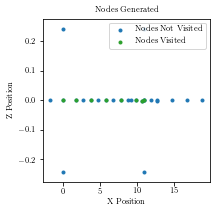

In [21]:
#plot the nodes generated by the search algorithm
print ("Number of nodes: ",len(astar_search.nodes_list))
fig = plt.figure(figsize=(3, 3))
#plt.ylim(ymax = 5.5, ymin = -1)
plot_nodes_astar(astar_search.nodes_list)
#overlay_bounds()

#plt.savefig('force_based_nodes.pgf')

In [22]:
#get the input sequence from search algorithm
input_seq_a = astar_search.get_input_seq()
print ("The input sequence:")
print ("  F_z           F_x")
print (input_seq_a)

The input sequence:
  F_z           F_x
[[0.     1.1566 1.    ]
 [0.     1.1566 1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     0.8434 1.    ]
 [0.     0.8434 1.    ]
 [0.     0.     1.    ]
 [0.     0.     1.    ]]


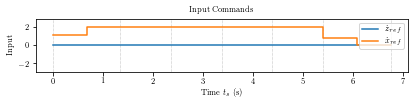

In [23]:
#plot the input sequence
Tsample = ts
k = 0
t = []
vz = []
vx = []
for u in input_seq_a:
    t.append(k*Tsample)
    t.append((k+1)*Tsample)
    vz.append(u[0])
    vz.append(u[0])
    vx.append(u[1])
    vx.append(u[1])
    k += 1

fig = plt.figure(figsize= [5.8, 1.5])
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.set_title('Desired Input Sequence')
ax.set_title(r'Input Commands')
ax.set_xlabel(r'Time $t_{s}$ (s)')
ax.set_ylabel('Input')

#ax.axis([-0.1, 3.5, -5.9,  5.9])


plt.ylim(ymin = -3, ymax =3)
t_pos = 0
plt.plot([0,0],[-6,6], color = 'grey', ls = ':', lw = 0.5)
for n in astar_search.path:
    duration = U[n.input_type].shape[0]
    plt.plot([t_pos + ts*duration,t_pos + ts*duration],[-6,6], color = 'grey', ls = ':', lw = 0.5)
    t_pos += ts*duration

plt.plot(t, vz, label = r"$\dot{z}_{ref}$")
plt.plot(t, vx, label = r"$\dot{x}_{ref}$")
ax.axis(ylim = (-5.9,  5.9))
plt.legend(loc = 'upper right')
plt.tight_layout()
#plt.savefig('complex_pgf/comp_hor_input.pgf')


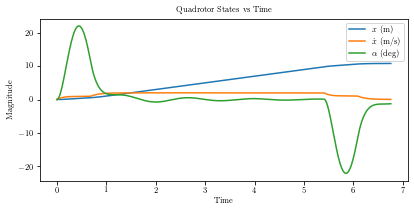

In [24]:
#plot the states for the input sequence
plt.rcParams['figure.figsize'] = 5.8, 3
quadrotor = Quadrotor(m=m)
result_a,t_a = quadrotor.solve(ts,xi,input_seq_a[:,0], input_seq_a[:,1],input_seq_a[:,2], t_eval = 0.001)
quadrotor.plot_states()
plt.tight_layout()
#plt.savefig('force_plant_states.pgf')

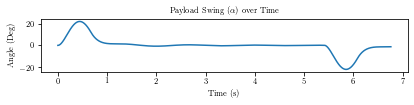

In [25]:
#Plot the payload swing over time
fig = plt.figure(figsize=(5.8, 1.5))
plt.title(r"Payload Swing $(\alpha)$ over Time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Deg)")
plt.plot(t_a,result_a[4,:]*180/np.pi)
plt.tight_layout()
#plt.savefig('complex_pgf/comp_hor_alpha.pgf')

In [26]:
#Function for plotting the position of the quadrotor woth suspended payload
def plot_position(result_a,t_a,positions):

 
    z_quad_a = result_a[0,:]
    x_quad_a = result_a[2,:]
    alpha_a = result_a[4,:]
    L = 0.5

    z_mass_a = z_quad_a-L*np.cos(alpha_a)
    x_mass_a = x_quad_a-L*np.sin(alpha_a)                 
    plt.title("Path Followed by Quadrotor")
    plt.plot(x_mass_a, z_mass_a, label = 'Mass', ls ='--', lw = 0.5)
    plt.plot(x_quad_a,z_quad_a, label = 'Quadrotor', ls ='--', color = 'tab:blue', lw = 0.5)           
    for p in positions:
        link = plt.Line2D((x_quad_a[p], x_mass_a[p]), (z_quad_a[p], z_mass_a[p]), lw=0.5, color = 'k')
        plt.gca().add_line(link)
        mass = plt.Circle((x_mass_a[p], z_mass_a[p]), 0.07, fc='k')
        plt.gca().add_patch(mass)

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    #plt.legend(loc = 'best')
    #plt.show()      

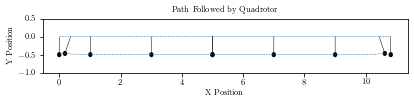

In [27]:
fig = plt.figure(figsize=(5.8, 1.5))
plt.ylim(ymax = .5, ymin = -1)
positions = [0, 500, 1000, 2000, 3000,3000, 4000, 5000,5900,6600]
plot_position(result_a,t_a,positions )
plt.tight_layout()
#plt.savefig('complex_pgf/comp_hor_path.pgf')

### Tunnel Chimney Tunnel

In [28]:
#define the boundaries
def bounds(y):
    #unpack the state variables
    z_quad = y[0,:]
    zd_quad = y[1,:]
    x_quad = y[2,:]
    xd_quad = y[3,:]
    a = y[4,:]
    ad = y[5,:]
    
    L = 0.5
    
    #calculate the position of the mass
    z_mass = z_quad-L*np.cos(a)
    x_mass = x_quad-L*np.sin(a)
    
    is_valid = True
    
    # all values of x_mass, z_mass, alpha, x_quad, z_quad
    for x_m, z_m, a_m, x_q, z_q, x_d in zip(x_mass,z_mass,a,x_quad,z_quad,xd_quad):
        #Section 1
        if (x_m < 16):
            if (z_m < -0.55):
                is_valid = False
            if (z_m > 0.05):
                is_valid = False
        if (x_q < 16):
            if (z_q < -0.55):
                is_valid = False
            if (z_q > 0.05):
                is_valid = False
        #Section 2
        if (x_m > 16) and (x_m < 20):
            if (z_m < -0.55) or (z_m > 5):
                is_valid = False
        if (x_q > 16) and (x_q < 20):
            if (z_q < -0.55) or (z_q > 5):
                is_valid = False       
        #Section 3
        if (x_m > 20):
            if (z_m < 4) or (z_m > 5):
                is_valid = False
        if (x_q > 20):
            if (z_q < 4) or (z_q > 5):
                is_valid = False                       
        if (x_q < 0):
            is_valid = False           
        if (x_q > 30):
            is_valid = False                       
    #    
    #    #wall behind goal
    #    if (x_m > 45):
    #        is_valid = False
    #    
        #limit Alpha
        if (np.abs(a_m) > np.pi/4):
            is_valid = False

    return is_valid
    
    

In [29]:
#define the goal objective
def goal(x):
    z_pos = x[0]
    z_dot = x[1]
    x_pos = x[2]
    x_dot = x[3]
    a = x[4]
    a_dot = x[5]
    goal = True
    if (x_pos < 25):
        goal = False
    if (np.abs(x_dot) > 1):
        goal = False    
    if goal:
        print ("Success")
    return goal

In [30]:
#function to overlay obstacles
def overlay_bounds():
    #Add obstacles
    points1 = [[-1, 0.05],[16,0.05],[16, 5],[30, 5],[30,4],[20,4],[20,-0.55],[-1,-0.55]]
    polygon1 = plt.Polygon(points1, fill=None, edgecolor='tab:brown')
    plt.gca().add_patch(polygon1)

In [31]:
#Define estimate of cost to goal region
def cost_to_go_a(x):
    x_goal = 25
    z_goal = 5
    z_quad = x[0]
    x_quad = x[2]
    return (np.sqrt((x_goal - x_quad)**2 + (z_goal - z_quad)**2))

In [32]:
#initialise the algorithm
astar_search = Astar(xi,goal,U,valid_u,f,cost_to_come_a,cost_to_go_a,bounds)
#search for the path
path_a = astar_search.search_path()


Success


Number of nodes:  362


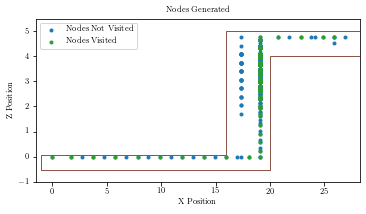

In [33]:
#plot the nodes generated by the search algorithm
print ("Number of nodes: ",len(astar_search.nodes_list))
fig = plt.figure(figsize=(5.8, 3))
plt.ylim(ymax = 5.5, ymin = -1)
plot_nodes_astar(astar_search.nodes_list)
overlay_bounds()

#plt.savefig('force_based_nodes.pgf')

In [34]:
#get the input sequencec for the planned path
input_seq_a = astar_search.get_input_seq()
print ("The input sequence:")
print ("  F_z           F_x")
print (input_seq_a)

The input sequence:
  F_z           F_x
[[0.     1.1566 1.    ]
 [0.     1.1566 1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     2.     1.    ]
 [0.     0.8434 1.    ]
 [0.     0.8434 1.    ]
 [0.     0.     1.    ]
 [0.     0.     1.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]
 [1.     0.     2.    ]


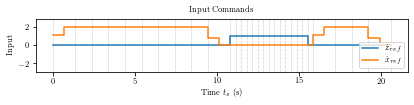

In [35]:
#plot the input sequence nicely
Tsample = ts
k = 0
t = []
vz = []
vx = []
for u in input_seq_a:
    t.append(k*Tsample)
    t.append((k+1)*Tsample)
    vz.append(u[0])
    vz.append(u[0])
    vx.append(u[1])
    vx.append(u[1])
    k += 1

fig = plt.figure(figsize= [5.8, 1.5])
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.set_title('Desired Input Sequence')
ax.set_title(r'Input Commands')
ax.set_xlabel(r'Time $t_{s}$ (s)')
ax.set_ylabel('Input')

#ax.axis([-0.1, 3.5, -5.9,  5.9])


plt.ylim(ymin = -3, ymax =3)

t_pos = 0
plt.plot([0,0],[-6,6], color = 'grey', ls = ':', lw = 0.5)
for n in astar_search.path:
    duration = U[n.input_type].shape[0]
    plt.plot([t_pos + ts*duration,t_pos + ts*duration],[-6,6], color = 'grey', ls = ':', lw = 0.5)
    t_pos += ts*duration

plt.plot(t, vz, label = r"$\dot{z}_{ref}$")
plt.plot(t, vx, label = r"$\dot{x}_{ref}$")
ax.axis(ylim = (-5.9,  5.9))
plt.legend(loc = 'lower right')
plt.tight_layout()
#plt.savefig('complex_pgf/comp_tct_input.pgf')

### Verify the choosen path

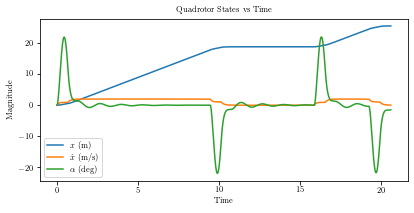

In [36]:
#simulate the planned path
quadrotor = Quadrotor(m=m)
result_a,t_a = quadrotor.solve(ts,xi,input_seq_a[:,0], input_seq_a[:,1],input_seq_a[:,2], t_eval = 0.001)
plt.rcParams['figure.figsize'] = 5.8, 3
quadrotor.plot_states()
plt.tight_layout()
#plt.savefig('force_plant_states.pgf')

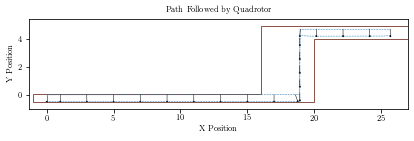

In [37]:
#plot the path followed by the quadrotor
fig = plt.figure(figsize=(5.8, 2))
plt.ylim(ymax = 5.5, ymin = -1)
positions = [0, 1000, 2000,3000,4000, 5000, 6000,7000,8000, 9000, 10000, 11000,12000, 13000, 
             14000, 15000,16000,17000,18000,19000,20618]
plot_position(result_a,t_a,positions )
plt.tight_layout()
overlay_bounds()
#plt.savefig('primitive_tun_chim_tun.pgf')
#plt.savefig('prim_pgf/prim_tct_path.pgf')
#plt.savefig('complex_pgf/comp_tct_path.pgf')

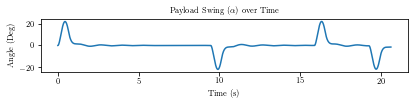

In [38]:
#payload swing angle
fig = plt.figure(figsize=(5.8, 1.5))
plt.title(r"Payload Swing $(\alpha)$ over Time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Deg)")
plt.plot(t_a,result_a[4,:]*180/np.pi)
plt.tight_layout()
#plt.savefig('complex_pgf/comp_tct_alpha.pgf')

In [39]:
result_a.shape

(6, 20619)

### Tunnel Chimney Tunnel with Obstacle

In [40]:
#define the boundaries of the environment
def bounds(y):
    #unpack the state variables
    z_quad = y[0,:]
    zd_quad = y[1,:]
    x_quad = y[2,:]
    xd_quad = y[3,:]
    a = y[4,:]
    ad = y[5,:]
    
    L = 0.5
    
    #calculate the position of the mass
    z_mass = z_quad-L*np.cos(a)
    x_mass = x_quad-L*np.sin(a)
    
    is_valid = True
    
    # all values of x_mass, z_mass, alpha, x_quad, z_quad
    for x_m, z_m, a_m, x_q, z_q, x_d in zip(x_mass,z_mass,a,x_quad,z_quad,xd_quad):
        #Section 1
        if (x_m < 16):
            if (z_m < -0.55):
                is_valid = False
            if (z_m > 0.05):
                is_valid = False
        if (x_q < 16):
            if (z_q < -0.55):
                is_valid = False
            if (z_q > 0.05):
                is_valid = False
        #add the obstacle        
        if (x_m > 5) and (x_m < 5.5):
            if (z_m < -0.4) or (z_m > 0.1):
                is_valid = False
        if (x_q > 5) and (x_q < 5.5):
            if (z_q < -0.4) or (z_q > 0.1):
                is_valid = False                       
        #Section 2
        if (x_m > 16) and (x_m < 20):
            if (z_m < -0.55) or (z_m > 5):
                is_valid = False
        if (x_q > 16) and (x_q < 20):
            if (z_q < -0.55) or (z_q > 5):
                is_valid = False       
        #Section 3
        if (x_m > 20):
            if (z_m < 4) or (z_m > 5):
                is_valid = False
        if (x_q > 20):
            if (z_q < 4) or (z_q > 5):
                is_valid = False                       
        if (x_q < 0):
            is_valid = False           
        if (x_q > 30):
            is_valid = False                       
    #    
    #    #wall behind goal
    #    if (x_m > 45):
    #        is_valid = False
    #    
        #limit Alpha
        if (np.abs(a_m) > np.pi):
            is_valid = False

    return is_valid
    

In [41]:
#initialise the algorithm
astar_search = Astar(xi,goal,U,valid_u,f,cost_to_come_a,cost_to_go_a,bounds)
#search for the path
path_a = astar_search.search_path()


Success


In [42]:
def overlay_bounds():
    #Add obstacles
    points1 = [[-1, 0.2],[16,0.2],[16, 5],[30, 5],[30,4],[20,4],[20,-0.7],
               [5.5,-0.7],[5.5,-0.45],[5,-0.45],[5,-0.7],[-1,-0.7],[-1,-0.7]]
    polygon1 = plt.Polygon(points1, fill=None, edgecolor='tab:brown', lw = 1)
    plt.gca().add_patch(polygon1)

Number of nodes:  263


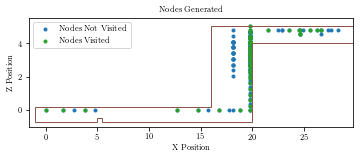

In [43]:
#plot the nodes generated by the search algorithm
print ("Number of nodes: ",len(astar_search.nodes_list))
fig = plt.figure(figsize=(5.8, 2))
plt.ylim(ymax = 5.5, ymin = -1)
plot_nodes_astar(astar_search.nodes_list)
overlay_bounds()

#plt.savefig('force_based_nodes.pgf')

In [44]:
#get the input sequence for the planned path
input_seq_a = astar_search.get_input_seq()
print ("The input sequence:")
print ("  F_z           F_x")
print (input_seq_a)

The input sequence:
  F_z           F_x
[[ 0.      1.1566  1.    ]
 [ 0.      1.1566  1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.      1.    ]
 [ 0.      0.      1.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.  

In [1]:
#plot the input sequence
Tsample = ts
k = 0
t = []
vz = []
vx = []
fx = []
for u in input_seq_a:
    type_in = u[2]
    t.append(k*Tsample)
    t.append((k+1)*Tsample)
    
    if type_in == 0:
        print ("n")
        vz.append(0.0)
        vz.append(0.0)
        vx.append(0.0)
        vx.append(0.0)
        fx.append(u[1])
        fx.append(u[1])
    else:
        vz.append(u[0])
        vz.append(u[0])
        vx.append(u[1])
        vx.append(u[1])
        fx.append(0)
        fx.append(0)        
    k += 1

fig = plt.figure(figsize= [3.3, 2.2])
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.set_title('Desired Input Sequence')
ax.set_title(r'Generated input commands')
ax.set_xlabel(r'Time (s)')
ax.set_ylabel('Input reference')

#ax.axis([-0.1, 3.5, -5.9,  5.9])


#plt.ylim(ymin = -7.5, ymax =7.5)

t_pos = 0
plt.plot([0,0],[-9,9], color = 'grey', ls = ':', lw = 0.5)
for n in astar_search.path:
    duration = U[n.input_type].shape[0]
    plt.plot([t_pos + ts*duration,t_pos + ts*duration],[-9,9], color = 'grey', ls = ':', lw = 0.5)
    t_pos += ts*duration

plt.plot(t, vz,lw = 1, label = r"$\dot{z}_{\textrm{ref}}$")
plt.plot(t, vx,lw = 1, label = r"$\dot{x}_{\textrm{ref}}$")
plt.plot(t, fx,lw = 1, label = r"$F_{x}$")
plt.ylim(ymin = -9, ymax =9)

plt.legend(loc = 'lower right')
plt.tight_layout()


NameError: name 'ts' is not defined

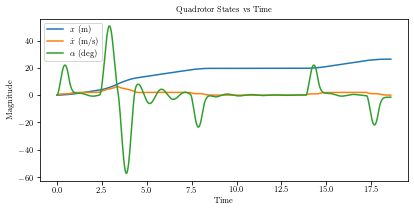

In [46]:
#plot the states for the simulation
quadrotor = Quadrotor(m=m)
result_a,t_a = quadrotor.solve(ts,xi,input_seq_a[:,0], input_seq_a[:,1],input_seq_a[:,2], t_eval = 0.001)
plt.rcParams['figure.figsize'] = 5.8, 3
quadrotor.plot_states()
plt.tight_layout()
#plt.savefig('force_plant_states.pgf')

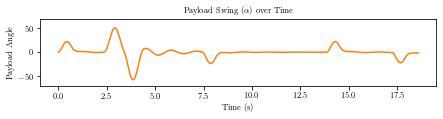

In [47]:
#plot the swing of the payload
fig = plt.figure(figsize=(6.2, 1.7))
plt.title(r"Payload Swing $(\alpha)$ over Time")
plt.xlabel("Time (s)")
plt.ylabel("Payload Angle")
plt.ylim(ymin = - 70, ymax = 70)
plt.plot(t_a,result_a[4,:]*180/np.pi, color = 'tab:orange')
plt.tight_layout()
#plt.savefig('comp_tct_obs_alpha.pdf')

In [48]:
#function to plot the position of the quadrotor with suspended payload
def plot_position(result_a,t_a,positions):

 
    z_quad_a = result_a[0,:]
    x_quad_a = result_a[2,:]
    alpha_a = result_a[4,:]
    L = 0.5

    z_mass_a = z_quad_a-L*np.cos(alpha_a)
    x_mass_a = x_quad_a-L*np.sin(alpha_a)                 
    plt.title("Path Followed by Quadrotor")
    plt.plot(x_mass_a, z_mass_a, label = 'Mass', ls ='--', lw = 1)
    plt.plot(x_quad_a,z_quad_a, label = 'Quadrotor', ls ='--', color = 'tab:blue', lw = 1)           
    for p in positions:
        link = plt.Line2D((x_quad_a[p], x_mass_a[p]), (z_quad_a[p], z_mass_a[p]), lw=0.5, color = 'k')
        plt.gca().add_line(link)
        mass = plt.Circle((x_mass_a[p], z_mass_a[p]), 0.07, fc='k')
        plt.gca().add_patch(mass)

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    #plt.legend(loc = 'best')
    #plt.show()      

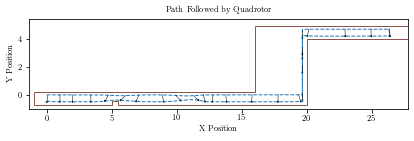

In [49]:
#plot the position of the quadrotor with suspended payload
fig = plt.figure(figsize=(5.8, 2))
plt.ylim(ymax = 5.5, ymin = -1)
positions = [0, 1000, 1500,2200,2700, 3000, 3200,3500,4000, 4200, 4500, 5000,3700, 6000, 
              7000, 8000,9000,11000,12000,12331, 13500, 14500, 16000, 17000, 18000,18172]
plot_position(result_a,t_a,positions )
plt.tight_layout()
overlay_bounds()
#plt.savefig('comp_tct_obs_path.png', dpi = 500)


In [50]:
quadrotor = Quadrotor(m=m)
result_a,t_a = quadrotor.solve(ts,xi,input_seq_a[:,0], input_seq_a[:,1],input_seq_a[:,2], t_eval = 0.001)

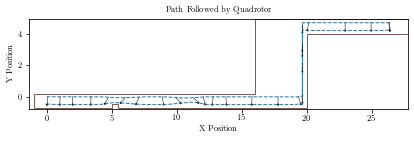

In [51]:
fig = plt.figure(figsize=(5.8, 2))
#plt.ylim(ymax = 5.5, ymin = -1)
positions = [0, 1000, 1500,2200,2700, 3000, 3200,3500,4000, 4200, 4500, 5000,3700, 6000, 
              7000, 8000,9000,11000,12000,12331, 13500, 14500, 16000, 17000, 18000,18172]
plot_position(result_a,t_a,positions )
plt.tight_layout()
overlay_bounds()
#plt.savefig('comp_tct_obs_path.png', dpi = 500)


# Export action sequence to Matlab Simulation

In [52]:
#Export the input sequence generated by the path planning algorithm
input_seq_a = astar_search.get_input_seq()
print ("The input sequence:")
print ("  r_z  r_x")
print (input_seq_a)
numbers_needed = input_seq_a.shape[0]
t = np.linspace(0,numbers_needed*ts,numbers_needed, endpoint = False)
rz = input_seq_a[:,0]
rx = input_seq_a[:,1]
input_type = input_seq_a[:,2]
sio.savemat('generated_input_sequences/complex_action_sec.mat', {'t':t.astype(float).T,'rz':rz.astype(float).T,'rx':rx.astype(float).T,'input_type':input_type.astype(float).T})

The input sequence:
  r_z  r_x
[[ 0.      1.1566  1.    ]
 [ 0.      1.1566  1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.      1.    ]
 [ 0.      0.      1.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.   

# Import data from matlab simulation

### Import the expected trajectory

In [53]:
f = sio.loadmat('../simulation_complex_action_space/matlab_outputs/expected_trajectory.mat')
a_p = f['path_a_dat']
x_p = f['path_x_pos_dat']
tout_p = f['tout']
x_p = f['path_x_pos_dat']
x_dot_p = f['path_x_dot_dat']
z_p = f['path_z_pos_dat']
z_dot_p = f['path_z_dot_dat']
fz_p = f['path_fz_dat']
fx_p = f['path_fx_dat']

### Import the executed path

In [54]:
g = sio.loadmat('../simulation_complex_action_space/matlab_outputs/no_disturbances.mat')
a_a = g['actual_a_dat'][0,:,:].T
a_dot_a = g['actual_a_dot_dat']
tout_a = g['tout']
x_a = g['actual_x_dat'][0,:,:].T
x_dot_a = g['actual_x_dot_dat']
z_a = g['actual_z_dat'][0,:,:].T
z_dot_a = g['actual_z_dot_dat']
f1_a = g['actual_f1_dat']
f2_a = g['actual_f2_dat']
theta_a = g['actual_theta_dat']
u1_a = g['actual_u1_dat']

In [55]:
x_a.shape

(18519, 1)

### Import the executed path with disturbances

In [56]:
h = sio.loadmat('../simulation_complex_action_space/matlab_outputs/with_disturbances.mat')
a_d = h['actual_a_dat'][0,:,:].T
a_dot_d = h['actual_a_dot_dat']
tout_d = h['tout']
x_d = h['actual_x_dat'][0,:,:].T
x_dot_d = h['actual_x_dot_dat']
z_d = h['actual_z_dat'][0,:,:].T
z_dot_d = h['actual_z_dot_dat']
f1_d = h['actual_f1_dat']
f2_d = h['actual_f2_dat']
theta_d = h['actual_theta_dat']
u1_d = h['actual_u1_dat']

# Plot graphs for report

In [57]:
#function for p
def plot_position(z, x , a, t_a, positions = [], color = 'tab:blue', label = ""):
 
    z_quad_a = z
    x_quad_a = x
    alpha_a = a
    L = 0.5

    z_mass_a = z_quad_a-L*np.cos(alpha_a)
    x_mass_a = x_quad_a-L*np.sin(alpha_a)                 
    
    plt.plot(x_mass_a, z_mass_a, ls ='--', color = color, lw = 0.5)
    plt.plot(x_quad_a,z_quad_a,ls ='--', color = color, lw = 0.5, label = label)           
    for p in positions:
        link = plt.Line2D((x_quad_a[p], x_mass_a[p]), (z_quad_a[p], z_mass_a[p]), lw=0.5, color = 'k')
        plt.gca().add_line(link)
        mass = plt.Circle((x_mass_a[p], z_mass_a[p]), 0.07, fc='k')
        plt.gca().add_patch(mass)
    #plt.legend(loc = 'best')
    #plt.show()      

In [58]:
def overlay_bounds():
    #Add obstacles
    points1 = [[-1, 0.2],[16,0.2],[16, 5],[30, 5],[30,4],[20,4],[20,-0.78],
               [5.5,-0.78],[5.5,-0.5],[5,-0.5],[5,-0.78],[-1,-0.78],[-1,-0.78]]
    polygon1 = plt.Polygon(points1, fill=None, edgecolor='tab:brown', lw = 1)
    plt.gca().add_patch(polygon1)

## Planned Path

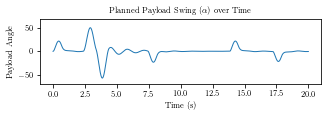

In [59]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.6, 1.67])
plt.title(r"Planned Payload Swing $(\alpha)$ over Time")
plt.xlabel("Time (s)")
plt.ylabel("Payload Angle")
plt.ylim(bottom = - 70, top = 70)
plt.plot(tout_p,a_p*180/np.pi, lw = 1)
plt.tight_layout()
plt.savefig('report_images/complex_alpha.pgf')
#plt.savefig('out.pdf')


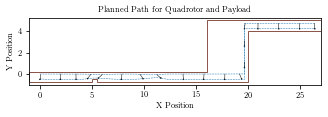

In [60]:
fig = plt.figure(figsize= [4.6, 1.67])
plt.xlim(left = -1, right = 27)
plt.ylim(bottom = -1, top = 5.2)
overlay_bounds()
positions = [0, 300, 450, 550, 600, 670, 730, 800, 1000, 1200, 1400, 1570, 2000, 2400, 2800, 3000, 3200, 3400, 3700]
plt.title("Planned Path for Quadrotor and Payload")

plot_position(z_p,x_p,a_p, tout_p,positions )
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.tight_layout()
#plt.savefig('report_images/complex_path.pgf')
plt.savefig('out.pdf')

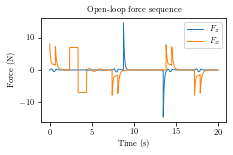

In [61]:
fig = plt.figure(figsize= [3.3, 2.2])
plt.title(r'Open-loop force sequence')
plt.xlabel(r'Time (s)')
plt.ylabel('Force (N)')
plt.tight_layout()
plt.plot(tout_p, fz_p, lw = 1, label = r"$F_{z}$")
plt.plot(tout_p, fx_p, lw = 1, label = r"$F_{x}$")
plt.legend(loc = 'upper right')
plt.savefig('report_images/complex_input.pgf')
#plt.savefig('out.pdf')

## Executed Path

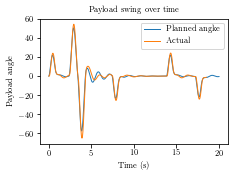

In [62]:
#plot the swing of the payload
fig = plt.figure(figsize= [3.3, 2.5])
plt.title(r"Payload swing over time")
plt.xlabel("Time (s)")
plt.ylabel("Payload angle")
#plt.ylim(bottom = - 70, top = 70)
plt.plot(tout_p,a_p*180/np.pi, lw = 1, label = 'Planned angke')
plt.plot(tout_a,a_a*180/np.pi, lw = 1, label = 'Actual')
plt.legend(loc = 'upper right')
#plt.axis("equal")
plt.tight_layout()

#plt.savefig('out.pdf')

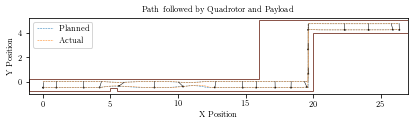

In [63]:
fig = plt.figure(figsize= [5.8, 1.8])
plt.xlim(left = -1, right = 27)
plt.ylim(bottom = -1, top = 5.2)
overlay_bounds()
positions = [0, 1000, 2000, 2600, 3000, 3400, 3700, 4500, 5500, 6000, 6700, 7300, 8000, 10000, 12000, 14000, 15700, 16600, 17500, 18300]
plt.title("Path followed by Quadrotor and Payload")

plot_position(z_p,x_p,a_p, tout_p,[], label = 'Planned')

plot_position(z_a,x_a,a_a, tout_a,positions,'tab:orange' , label = 'Actual')
plt.legend(loc = 'upper left')
plt.xlabel('X Position')
plt.ylabel('Y Position')
#plt.axis("equal")
plt.tight_layout()
plt.savefig('out.pdf')

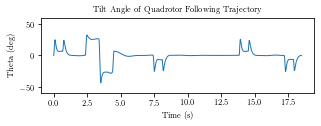

In [64]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.5, 1.8])
plt.title(r"Tilt Angle of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Theta (deg)")
plt.ylim(bottom = - 60, top = 60)
plt.plot(tout_a,theta_a*180/np.pi, lw =1 )
plt.tight_layout()
plt.savefig('out.pdf')

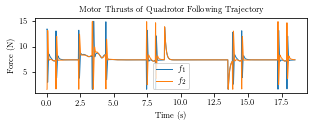

In [65]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.5, 1.8])
plt.title(r"Motor Thrusts of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.plot(tout_a[30:],f1_a[30:], lw =1 , label = r"$f_{1}$")
plt.plot(tout_a[30:],f2_a[30:], lw =1 ,label = r"$f_{2}$")
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('out.pdf')


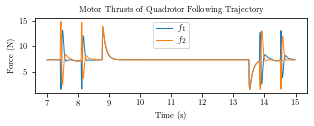

In [66]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.5, 1.8])
plt.title(r"Motor Thrusts of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.plot(tout_a[7000:15000],f1_a[7000:15000], lw = 1, label = r"$f_{1}$")
plt.plot(tout_a[7000:15000],f2_a[7000:15000], lw = 1, label = r"$f_{2}$")
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.savefig('out.pdf')


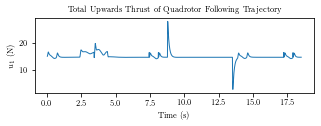

In [67]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.5, 1.8])
plt.title(r"Total Upwards Thrust of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("$u_1$ (N)")
plt.plot(tout_a[40:],u1_a[40:], lw =1 )
plt.tight_layout()
plt.savefig('out.pdf')

## Executed Path with Disturbances

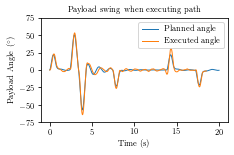

In [68]:
#plot the swing of the payload
fig = plt.figure(figsize= [3.3, 2.2])
plt.title(r"Payload swing when executing path")
plt.xlabel("Time (s)")
plt.ylabel("Payload Angle ($^{\circ}$)")
plt.ylim(bottom = - 75, top = 75)
plt.plot(tout_p,a_p*180/np.pi, lw = 1, label = 'Planned angle')
plt.plot(tout_d,a_d*180/np.pi, lw = 1, label = 'Executed angle')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('report_images/sim_alpha.pgf')
#plt.savefig('out.pdf')

In [69]:
#function for p

#modify the function to receive angles and draw them 

def plot_position(z, x , a, t_a, theta_d, positions = [], color = 'tab:blue', label = ""):
 
    z_quad_a = z
    x_quad_a = x
    alpha_a = a
    L = 0.5

    z_mass_a = z_quad_a-L*np.cos(alpha_a)
    x_mass_a = x_quad_a-L*np.sin(alpha_a)                 
    
    plt.plot(x_mass_a, z_mass_a, ls ='--', color = color, lw = 0.5)
    plt.plot(x_quad_a,z_quad_a,ls ='--', color = color, lw = 0.5, label = label)   
    
    body_length = 0.3
    
    hor_displace = np.cos(theta_d)*body_length/2
    vert_displace = np.sin(theta_d)*body_length/2
    for p in positions:
        #create a line for the body of the quadcopter
        x_corner = (x_quad_a[p]+hor_displace[p], x_quad_a[p]-hor_displace[p])
    
        
        z_corner = (z_quad_a[p]-vert_displace[p],z_quad_a[p]+vert_displace[p])
        
        body = plt.Line2D(x_corner, z_corner, lw=0.5, color = 'k')
        plt.gca().add_line(body)
        link = plt.Line2D((x_quad_a[p], x_mass_a[p]), (z_quad_a[p], z_mass_a[p]), lw=0.5, color = 'k')
        plt.gca().add_line(link)
        mass = plt.Circle((x_mass_a[p], z_mass_a[p]), 0.07, fc='k')
        plt.gca().add_patch(mass)
    #plt.legend(loc = 'best')
    #plt.show()      

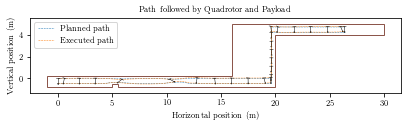

In [70]:
fig = plt.figure(figsize= [5.8, 1.8])
plt.xlim(left = -1, right = 27)
#plt.ylim(bottom = -1, top = 5.2)
overlay_bounds()
positions = np.linspace(0,len(tout_d)-1,25, dtype=int)
plt.title("Path followed by Quadrotor and Payload")

plot_position(z_p,x_p,a_p, tout_p,[], label = 'Planned path')

plot_position(z_d,x_d,a_d, tout_d,theta_d,positions,'tab:orange' , label = 'Executed path')
plt.legend(loc = 'upper left')
plt.xlabel('Horizontal position (m)')
plt.ylabel('Vertical position (m)')
plt.axis("equal")
plt.tight_layout()
#plt.savefig('report_images/sim_path.pgf')
plt.savefig('out.pdf')


In [71]:
np.linspace(0,len(tout_d),10, dtype=int)

array([    0,  7181, 14362, 21543, 28724, 35906, 43087, 50268, 57449,
       64631])

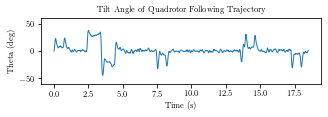

In [72]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.6, 1.67])
plt.title(r"Tilt Angle of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Theta (deg)")
plt.ylim(bottom = - 60, top = 60)
plt.plot(tout_d,theta_d*180/np.pi, lw =1 )

plt.tight_layout()
plt.savefig('report_images/sim_theta.pgf')
#plt.savefig('out.pdf')

In [73]:
np.cos(theta_d)

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [0.99965675],
       [0.99965534],
       [0.99965452]])

In [74]:
np.sin(theta_d)

array([[0.00000000e+00],
       [4.80111441e-12],
       [2.06984759e-11],
       ...,
       [2.61989033e-02],
       [2.62524687e-02],
       [2.62838582e-02]])

In [75]:
hor_displace = np.cos(theta_d)*0.3/2

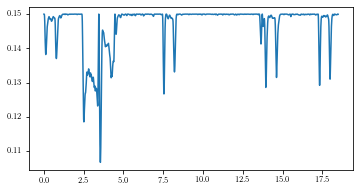

In [77]:
plt.plot(tout_d,hor_displace)

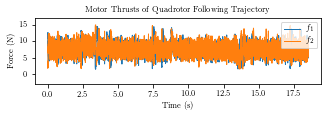

In [78]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.6, 1.67])
plt.title(r"Motor Thrusts of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.ylim(bottom = - 3, top = 17)
plt.plot(tout_d[60:],f1_d[60:], lw =1 , label = r"$f_{1}$")
plt.plot(tout_d[60:],f2_d[60:], lw =1 ,label = r"$f_{2}$")
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('report_images/sim_motor_thrust.pgf')
#plt.savefig('out.pdf')


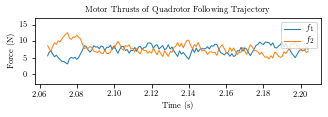

In [79]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.6, 1.67])
plt.title(r"Motor Thrusts of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.ylim(bottom = - 3, top = 17)
plt.plot(tout_d[7500:8000],f1_d[7500:8000], lw = 1, label = r"$f_{1}$")
plt.plot(tout_d[7500:8000],f2_d[7500:8000], lw = 1, label = r"$f_{2}$")
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('out.pdf')


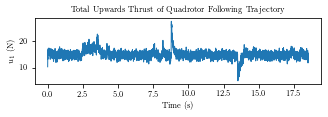

In [80]:
#plot the swing of the payload
fig = plt.figure(figsize= [4.6, 1.67])
plt.title(r"Total Upwards Thrust of Quadrotor Following Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("$u_1$ (N)")
plt.plot(tout_d[40:],u1_d[40:], lw =1 )
plt.tight_layout()
plt.savefig('out.pdf')

# Obstacle avoidance seq

In [81]:
result_o,t_o = quadrotor.solve(ts, xi, U[9][:,0], U[9][:,1], U[9][:,2], t_eval = 0.001)

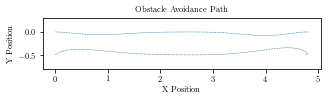

In [82]:
fig = plt.figure(figsize= [4.6, 1.45])
z_quad_a = result_o[0,:]
x_quad_a = result_o[2,:]
alpha_a = result_o[4,:]
positions = [0, 500, 700, 1000, 1300, 1500, 2000]
plt.ylim(bottom = -0.8, top = 0.3)
plot_position(z_quad_a,x_quad_a,alpha_a, t_o,positions)
plt.xlabel('X Position')
plt.title('Obstacle Avoidance Path')
plt.ylabel('Y Position')
plt.tight_layout()
#plt.savefig('out.pdf')
plt.savefig('report_images/obstacle_sec.pgf')